### Seminar 7: Intro to Neural Networks

Goals/Agenda
- Intro to PyTorch
- Linearly separable and non-separable classes
- Computation graph and backprop
- Logistic regression
- Perceptron
- MLP
- Training loop
- Dataloader
- CUDA acceleration

### Intro to PyTorch

First of all enable GPU in colab:

- Runtime-> Change runtime type->T4 GPU

### Attribution
Parts of this notebook are adapted from:
- [Introduction to PyTorch tutorial by Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html)

- [A Gentle Introduction to torch.autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)



In PyTorch we operate with tensor objects. These  are equivalent to array object in numpy, but optimized for accelerated calculations on GPU (will discuss it later).

In [76]:
import torch

# we can create a tensor from a list
a = torch.tensor([3.0, 2.1, 3.0])
print(a, a.shape)

tensor([3.0000, 2.1000, 3.0000]) torch.Size([3])


In [77]:
# or a nested list
a = torch.tensor([[3.0, 2.1, 3.0], [0.7, -1.2, 37]])
print(a, a.shape)

tensor([[ 3.0000,  2.1000,  3.0000],
        [ 0.7000, -1.2000, 37.0000]]) torch.Size([2, 3])


In [78]:
# or create arrays using torch factory method
a = torch.ones(3, 4) # a 2D tensor of shape 3 x 4 filled with ones
print(a, a.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]) torch.Size([3, 4])


In [79]:
a = torch.arange(1, 10, 2) # 1D tensor with values from 1 to 10 with step of 2
print(a, a.shape)

tensor([1, 3, 5, 7, 9]) torch.Size([5])


### Broadcasting

In [80]:
a = torch.tensor([-1])
b = torch.arange(3, 10, 1)
print(b)
print(a + b)

tensor([3, 4, 5, 6, 7, 8, 9])
tensor([2, 3, 4, 5, 6, 7, 8])


In [81]:
a = torch.arange(3, 10, 1)
b = torch.arange(3, 10, 1)

print(a + b)

tensor([ 6,  8, 10, 12, 14, 16, 18])


In [82]:
a = torch.arange(3, 10, 1).reshape(-1, 1) # be careful with dimensions
b = torch.arange(3, 10, 1)

print(a + b)

tensor([[ 6,  7,  8,  9, 10, 11, 12],
        [ 7,  8,  9, 10, 11, 12, 13],
        [ 8,  9, 10, 11, 12, 13, 14],
        [ 9, 10, 11, 12, 13, 14, 15],
        [10, 11, 12, 13, 14, 15, 16],
        [11, 12, 13, 14, 15, 16, 17],
        [12, 13, 14, 15, 16, 17, 18]])


In [83]:
a = torch.rand(3, 10) # 2D tensor with random values between 0 and 1
b = torch.rand(10, 2)

In [84]:
# matrix product
c = torch.matmul(a, b) # 3 x 2
print(c)

tensor([[1.9196, 1.7407],
        [2.6429, 2.0949],
        [2.8761, 2.5857]])


### Torch to numpy and vice versa

In [85]:
import numpy as np

a = np.array([0.0, 42.0])
t = torch.from_numpy(a)

In [86]:
t = torch.rand(4, 9)
a = t.numpy()

In [87]:
a.shape

(4, 9)

### Computation graph

#### Toy example

- Assume we have some neural network model with parameters $a$ and $b$.

- The error function is given by $Q = 3a^3 - b^2$



- We want to minimize a loss function $Q$ with respect to $a$ and $b$.

The gradients are calculated as follows:

$$\frac{\partial Q}{\partial a} = 9a^2$$

$$\frac{\partial Q}{\partial b} = -2b$$

Gradient descent update:
$$a = a - \alpha \cdot \frac{\partial Q}{\partial a}$$
$$b = b - \alpha \cdot \frac{\partial Q}{\partial b}$$


We can calcucalate gradient manually as follows:

In [88]:
a = torch.tensor([2., 3.])
b = torch.tensor([6., 4.])
Q = 3 * a ** 3 - b ** 2

In [89]:
dQ_da = 9 * a ** 2
dQ_db = -2 * b

We can also accomplish this using automatic differentiation implemented in the `torch.autograd` system.

We create two tensors a and b with `requires_grad=True`. This tells autograd to track all operations performed on them.

In [90]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3 * a ** 3 - b ** 2

In [91]:
a.requires_grad, b.requires_grad

(True, True)

When `requires_grad=True`, `autograd` keeps a record of data (tensors) & all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects.

- In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

-   run the requested operation to compute a resulting tensor, and
-   maintain the operation's *gradient function* in the DAG.

Source: [A Gentle Introduction to torch.autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)



### Backpropagation

After the forward pass we can compute gradients using `.backward()` method.


The backward pass kicks off when `.backward()` is called on the DAG
root. `autograd` then:

-   computes the gradients from each `.grad_fn`,
-   accumulates them in the respective tensor's `.grad` attribute, and
-   using the chain rule, propagates all the way to the leaf tensors.

Below is a visual representation of the DAG in our example. In the
graph, the arrows are in the direction of the forward pass. The nodes
represent the backward functions of each operation in the forward pass.
The leaf nodes in blue represent our leaf tensors `a` and `b`.

![](https://pytorch.org/tutorials/_static/img/dag_autograd.png)

Source: [A Gentle Introduction to torch.autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)


In [92]:
external_grad = torch.ones_like(Q)
Q.backward(gradient=external_grad)

When we call `.backward()` on `Q`, autograd calculates these gradients
and stores them in the respective tensors\' `.grad` attribute.
We need to explicitly pass a `gradient` argument in `Q.backward()`
because it is a vector.

When we have a vector-valued function `Q` (a vector) and we want to compute the gradients of the components of `Q` with respect to the input tensors, `a` and `b`, we must provide a gradient argument to the backward method. This gradient argument is a tensor of the same shape as `Q` and it represents the weights in the linear combination of the components of `Q` for which we want to compute the gradients.

In particular, if we set gradient to a tensor of ones, we are computing the gradient of the sum of the elements of `Q` (because the derivative of the sum is the same as the derivative of each element multiplied by 1 and then summed).

Alternatively, if we first sum the vector `Q` to a scalar and then call backward (without any arguments because now it's a scalar), we get the same result.

So, the two are equivalent:

- `Q.backward(gradient=torch.ones_like(Q))`

- `Q.sum().backward()`



In [93]:
# manual vs. autograd
print(dQ_da == a.grad)
print(dQ_db == b.grad)

tensor([True, True])
tensor([True, True])


In [94]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3 * a ** 3 - b ** 2
Q = Q.sum()

In [95]:
Q.backward()

In [96]:
# manual vs. autograd
print(dQ_da == a.grad)
print(dQ_db == b.grad)

tensor([True, True])
tensor([True, True])



Exclusion from the DAG
----------------------

`torch.autograd` tracks operations on all tensors which have their
`requires_grad` flag set to `True`. For tensors that don't require
gradients, setting this attribute to `False` excludes it from the
gradient computation DAG.

The output tensor of an operation will require gradients even if only a
single input tensor has `requires_grad=True`.

### Still unclear? Let's walk through another example

### Linearly Separable Classes
Below is a toy example with two groups of samples corresponding to points lying below or above the line.


In [97]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

In [98]:
# download files
!mkdir data
!wget -O./data/linearly_separable_classes.csv https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar07/linearly_separable_classes.csv

mkdir: cannot create directory ‘data’: File exists
--2025-09-28 13:05:13--  https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar07/linearly_separable_classes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 845 [text/plain]
Saving to: ‘./data/linearly_separable_classes.csv’

./data/linearly_sep 100%[===================>]     845  --.-KB/s    in 0s      

2025-09-28 13:05:14 (64.4 MB/s) - ‘./data/linearly_separable_classes.csv’ saved [845/845]



In [99]:
data = pd.read_csv('data/linearly_separable_classes.csv')

x = torch.tensor(data[['f1', 'f2']].values, dtype=torch.float64)
y = torch.tensor(data['label'].values, dtype=torch.float64)

Text(0, 0.5, 'x2')

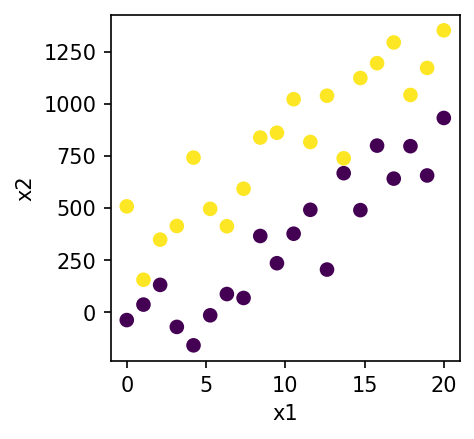

In [100]:
plt.figure(dpi = 150, figsize = (3, 3))
plt.scatter(x[:, 0], x[:, 1], c = y)
plt.xlabel('x1')
plt.ylabel('x2')

The classes are linearly separable. We first perform a linear transformation of the input:

$$z = x W + b$$

Then apply a non-linear transformation that maps $z$ to probability (i.e., value between 0 or 1) of a sample (f1, f2) corresponding to class 1.


One possible option is to use a logistic function (also called a sigmoid function):


$$f(z) = \frac{1}{1 + \exp\left(-z\right)}$$

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1920px-Logistic-curve.svg.png" height="300"></center>

After that, we will use the 0.5 threshold to make a decision.


$$
t(z) =
\begin{cases}
1 & \text{if } z \geq 0 \\
0 & \text{if } z < 0
\end{cases}
$$


To find the parameters of the model ($W$ and $b$) we need to define a cost function which we will minimize. This cost function is called binary cross-entropy loss.

$$
J(\mathbf{y}, \mathbf{\hat{y}}) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

In [101]:
def affine_transform(x, W, b):
    return torch.matmul(x, W) + b

def logistic_func(z):
    return 1/(1 + torch.exp(-z))

def cross_entropy_with_logits(y, z, epsilon = 1e-9):
    y_pred = logistic_func(z)
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon) # to deal with numerical instability
    return -torch.mean(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred))

In [102]:
W = torch.rand(x.shape[-1], dtype=torch.float64, requires_grad=True)
b = torch.rand(1, dtype=torch.float64, requires_grad=True)
z = affine_transform(x, W, b)

loss = cross_entropy_with_logits(y, affine_transform(x, W, b))

This code defines the following **computational graph**:

![](https://pytorch.org/tutorials/_static/img/basics/comp-graph.png)

We need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the `requires_grad` property of those tensors.


In [103]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7c7f74f72f20>
Gradient function for loss = <NegBackward0 object at 0x7c7f74f72f20>


In [104]:
loss_history = []
lr = 0.1
n_epochs = 500

# scale features
x = (x - x.mean(dim=0)) / x.std(dim=0)

for i in range(n_epochs):

    # get logits
    z = affine_transform(x, W, b)

    # calculate loss
    loss = cross_entropy_with_logits(y, z)

    # backward propagation
    loss.backward()

    with torch.no_grad():

        # update weights
        W -= lr * W.grad
        b -= lr * b.grad

        # zero gradients before the next iteration
        W.grad.zero_()
        b.grad.zero_()

    loss_history.append(loss.item())

Text(0, 0.5, 'Loss')

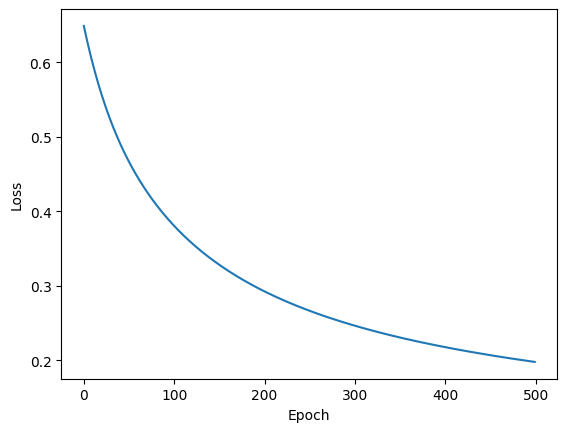

In [105]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [106]:
def accuracy(labels, preds):
    return (labels == preds).sum()/len(labels)

tr = 0.5
accuracy(y, torch.where(logistic_func(z) > tr, 1, 0))

tensor(1.)

In [107]:
# Final weights
print(W, b)

tensor([-2.4600,  3.5750], dtype=torch.float64, requires_grad=True) tensor([0.0393], dtype=torch.float64, requires_grad=True)


The fit accuracy is 100%.

### Task 1: Plot a decision boundary for the obtained model
Hint: The boundary is where `y_pred=0.5` , which occurs when `z = 0`

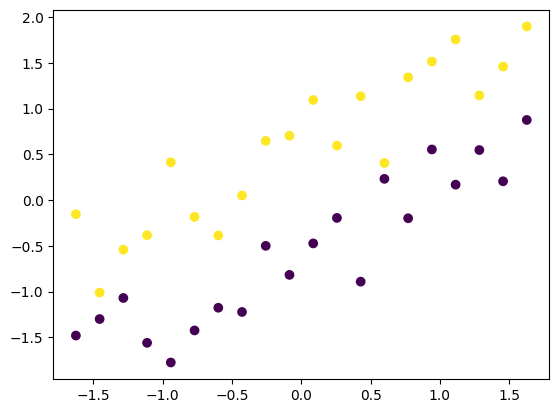

In [108]:
plt.scatter(*x.T, c = torch.where(logistic_func(z) > tr, 1, 0))

### your code ###

### Linearly non-separable classes


Text(0, 0.5, 'f2')

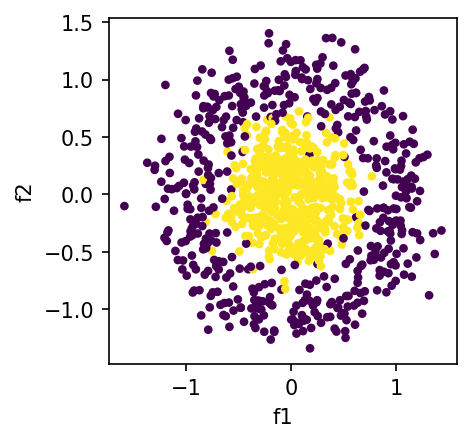

In [109]:
from sklearn.datasets import make_circles

x, labels = make_circles(n_samples=1000, noise = 0.2, factor = 0.3)

x = torch.from_numpy(x)
y = torch.from_numpy(labels)

plt.figure(dpi = 150, figsize = (3, 3))
plt.scatter(*x.T, c = labels, s = 10)
plt.xlabel('f1')
plt.ylabel('f2')

In [110]:
W = torch.rand(x.shape[-1], dtype=torch.float64, requires_grad=True)
b = torch.rand(1, dtype=torch.float64, requires_grad=True)
z = affine_transform(x, W, b)

loss = cross_entropy_with_logits(y, affine_transform(x, W, b))

In [111]:
loss_history = []
lr = 0.1
n_epochs = 500

# scale features
x = (x - x.mean(dim=0)) / x.std(dim=0)

for i in range(n_epochs):

    # get logits
    z = affine_transform(x, W, b)

    # calculate loss
    loss = cross_entropy_with_logits(y, z)

    # backward propagation
    loss.backward()

    with torch.no_grad():

        # update weights
        W -= lr * W.grad
        b -= lr * b.grad

        # zero gradients before the next iteration
        W.grad.zero_()
        b.grad.zero_()

    loss_history.append(loss.item())

Text(0, 0.5, 'Loss')

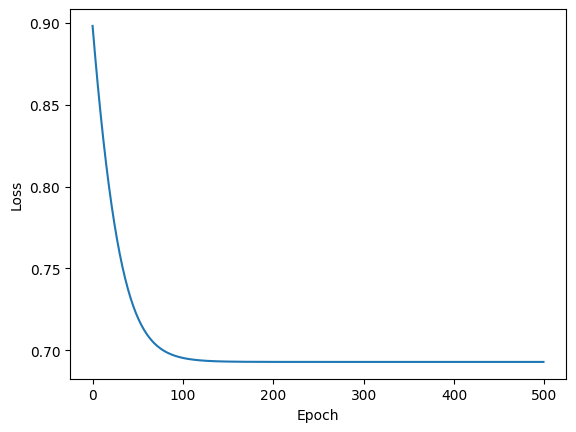

In [112]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [113]:
tr = 0.5
accuracy(y, torch.where(logistic_func(z) > tr, 1, 0))

tensor(0.5160)

Logistic Regression fails for this task, achieving an accuracy of approximately 50% - equivalent to random guessing or a coin flip.

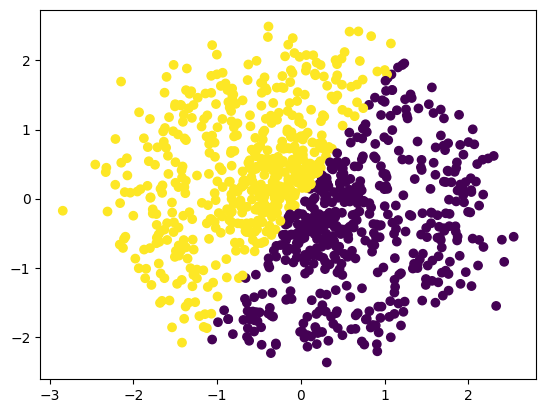

In [114]:
plt.scatter(*x.T, c = torch.where(logistic_func(z) > tr, 1, 0))

### Multilayer perceptron

In [115]:
from torch import nn
from torch.optim import SGD
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

PyTorch is a highly flexible and modular library that enables us to create custom classes using its modules and parameters as needed.

Our MLP class inherits from nn.Module to leverage PyTorch's built-in functionality, including methods like `parameters()`, `to(device)`, and automatic backpropagation.

In [116]:
class MLP(nn.Module):

    def __init__(self, input_dim, hidden_dim = 64, out_dim=1):
        super().__init__()

        # input layer
        self.in_fc = nn.Linear(input_dim,hidden_dim)

        # hidden layer
        self.hidden_fc = nn.Linear(hidden_dim, hidden_dim)

        # output layer
        self.out_fc = nn.Linear(hidden_dim, out_dim)

    def forward(self,x):
        x = self.in_fc(x)
        x = F.relu(x) # non-linear transformation
        x = self.hidden_fc(x)
        x = F.relu(x) # non-linear transformation
        x = self.out_fc(x)
        #x = F.sigmoid(x) # non-linear transformation to probabilities
        return x

In [117]:
# create model
model = MLP(input_dim=x.shape[1])

# define loss function
criterion = nn.BCEWithLogitsLoss()

# define optimizer and connect it to model parameters
optim = SGD(model.parameters(), lr = 1e-2)

x = x.to(torch.float32)
y = y.to(torch.float32)

# split data into train/val/test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)



lr = 1e-3
n_epochs = 5000
loss_history_train = []
loss_history_val = []

mean = X_train.mean(dim = 0)
std = X_train.std(dim = 0)

# scale features
X_train_scaled = (X_train - mean) / std
X_val_scaled = (X_val - mean) / std
X_test_scaled = (X_test - mean) / std

for epoch in range(n_epochs):

    # set model in a training regime
    model.train()

    # clear gradients from the previous step
    optim.zero_grad()

    # forward pass
    logits = model(X_train_scaled).flatten()
    loss = criterion(logits, y_train)

    # backward pass
    loss.backward()

    # update model parameters
    optim.step()

    loss_history_train.append(loss.item())

    # evaluate model
    model.eval()
    with torch.no_grad():
        logits = model(X_val_scaled).flatten()
        predictions = (logits.sigmoid() > 0.5).float()
        accuracy = (predictions.flatten() == y_val).float().mean()
        loss_history_val.append(criterion(logits, y_val).item())
    if epoch % 250 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 0, Loss: 0.6894, Accuracy: 0.4900
Epoch 250, Loss: 0.5983, Accuracy: 0.8000
Epoch 500, Loss: 0.4852, Accuracy: 0.9500
Epoch 750, Loss: 0.3543, Accuracy: 0.9500
Epoch 1000, Loss: 0.2505, Accuracy: 0.9600
Epoch 1250, Loss: 0.1884, Accuracy: 0.9500
Epoch 1500, Loss: 0.1539, Accuracy: 0.9500
Epoch 1750, Loss: 0.1340, Accuracy: 0.9500
Epoch 2000, Loss: 0.1219, Accuracy: 0.9500
Epoch 2250, Loss: 0.1139, Accuracy: 0.9500
Epoch 2500, Loss: 0.1084, Accuracy: 0.9500
Epoch 2750, Loss: 0.1044, Accuracy: 0.9500
Epoch 3000, Loss: 0.1015, Accuracy: 0.9500
Epoch 3250, Loss: 0.0993, Accuracy: 0.9500
Epoch 3500, Loss: 0.0975, Accuracy: 0.9500
Epoch 3750, Loss: 0.0962, Accuracy: 0.9500
Epoch 4000, Loss: 0.0950, Accuracy: 0.9500
Epoch 4250, Loss: 0.0941, Accuracy: 0.9500
Epoch 4500, Loss: 0.0933, Accuracy: 0.9500
Epoch 4750, Loss: 0.0927, Accuracy: 0.9500


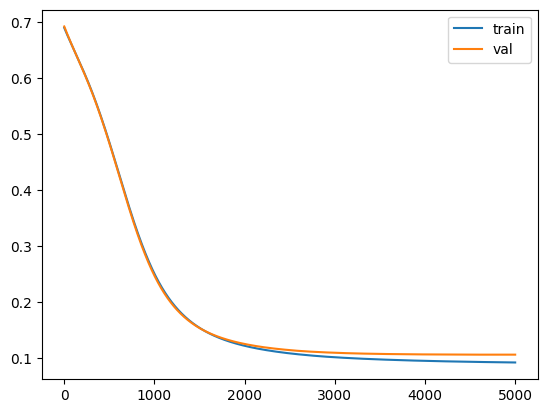

In [118]:
plt.plot(loss_history_train, label = 'train')
plt.plot(loss_history_val, label = 'val')
plt.legend()

In [119]:
with torch.no_grad():
    model.eval()
    y_preds = model(X_test_scaled).sigmoid()
    predictions = (y_preds > 0.5).float()

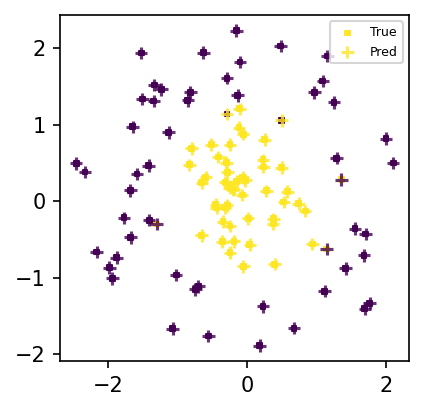

In [120]:
plt.figure(dpi = 150, figsize = (3, 3))
plt.scatter(*X_test.T, c = y_test, marker='s', s = 5, label = 'True')
plt.scatter(*X_test.T, c = predictions, marker = '+', alpha = 0.8, label = 'Pred')
plt.legend(fontsize = 6)

### Datasets, Dataloaders, Batching, and GPU Acceleration

1) GPU Acceleration with CUDA

PyTorch is optimized to perform calculations on NVIDIA GPUs using the CUDA platform. This enables significant acceleration for complex models and large datasets.

> "CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model that allows software to use specific types of graphics processing units (GPUs) for general-purpose processing. This significantly boosts performance, making it essential for scientific and high-performance computing." - adapted from [Wiki](https://en.wikipedia.org/wiki/CUDA)

2) The Need for Batches

In our previous examples, we used the entire training dataset to perform a single gradient descent step. However, this is inefficient and often impossible for real-world problems, which involve huge datasets. Using the full dataset for each update is computationally expensive, and the data may not even fit into the computer's memory. To solve this, we use batches - a non-overlapping pieces of a dataset.

3) The Dataset and DataLoader in PyTorch

PyTorch provides Dataset and DataLoader classes to handle these challenges. It efficiently manages large datasets by splitting them into batches, making the training process both manageable and efficient.

In [121]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class CustomDataset(Dataset):
    def __init__(self, X, y):

        self.y = y # labels
        self.X = X # features

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        x_sample = self.X[idx] # one sample
        y_sample = self.y[idx] # one sample

        return x_sample, y_sample


train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# ask for a sample with idx = 130
train_dataset.__getitem__(130)

(tensor([-1.4252,  0.4115]), tensor(0.))

In [122]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) # we randomly shuffle samples during training
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


for (X_batch, y_batch) in train_loader:
    break

print(X_batch)
print(y_batch)

tensor([[-0.6177, -2.0570],
        [ 1.4981, -0.4240],
        [-0.1563,  1.2674],
        [-1.8755,  0.8736],
        [ 0.2596, -0.2957],
        [ 1.5724, -0.8960],
        [ 0.1666, -0.3328],
        [-0.9561, -0.4940],
        [ 0.4372, -1.0690],
        [ 0.4506, -0.7536],
        [-0.2679,  0.4417],
        [-0.1301, -0.2272],
        [ 0.3200, -0.6708],
        [-0.4335,  1.7553],
        [-0.4940,  0.0235],
        [ 1.4054,  1.3054],
        [ 0.2767,  0.0793],
        [ 0.5474, -1.2605],
        [ 1.7739, -0.3985],
        [ 1.1138, -0.5089],
        [ 2.0303,  0.2952],
        [ 0.4772, -0.5119],
        [ 0.2720, -0.5924],
        [-0.0208,  1.1107],
        [-0.2125,  0.5448],
        [ 0.5669, -0.5818],
        [ 0.3734, -0.0533],
        [-1.2410,  0.3345],
        [-0.5849, -0.0126],
        [-0.4911,  0.4792],
        [-0.8241, -0.3434],
        [-0.3936,  2.3385],
        [ 0.2886, -1.0200],
        [ 2.4298, -0.9146],
        [-0.8479,  0.2459],
        [ 1.9681,  0

In [123]:
from tqdm import tqdm

# create model
model = MLP(input_dim=x.shape[1])

# define loss function
criterion = nn.BCEWithLogitsLoss()

# define optimizer and connect it to model parameters
optim = SGD(model.parameters(), lr = 1e-2)

lr = 1e-3
n_epochs = 2500
loss_history_train = []
loss_history_val = []

best_score = torch.inf

for epoch in tqdm(range(n_epochs)):

    loss_step = 0
    for (X_batch, y_batch) in train_loader:

        # set model in a training regime
        model.train()

        # clear gradients from the previous step
        optim.zero_grad()

        # forward pass
        logits = model(X_batch).flatten()
        loss = criterion(logits, y_batch)

        # backward pass
        loss.backward()

        # update model parameters
        optim.step()

        loss_step += loss.item()

    loss_history_train.append(loss_step/len(train_loader))

    loss_step = 0
    for (X_batch, y_batch) in val_loader:
        # evaluate model
        model.eval()
        with torch.no_grad():
            logits = model(X_batch).flatten()
            predictions = (logits.sigmoid() > 0.5).float()
            accuracy = (predictions.flatten() == y_batch).float().mean()

        loss_step += loss.item()

    loss_history_val.append(loss_step/len(val_loader))

    # save best model using validation loss
    if loss_history_val[-1] <= best_score:
        best_score = loss_history_val[-1]
        torch.save(model, 'best_model.pt')

    if epoch % 250 == 0:
        print(f'Epoch {epoch}, Loss train: {loss_history_train[-1]:.4f}, Loss val: {loss_history_val[-1]:.4f}')

  0%|          | 6/2500 [00:00<00:42, 58.80it/s]

Epoch 0, Loss train: 0.6796, Loss val: 0.6839


 11%|█         | 268/2500 [00:03<00:23, 93.46it/s]

Epoch 250, Loss train: 0.2283, Loss val: 0.2195


 21%|██        | 519/2500 [00:06<00:20, 95.67it/s]

Epoch 500, Loss train: 0.1195, Loss val: 0.0914


 30%|███       | 761/2500 [00:09<00:17, 98.23it/s]

Epoch 750, Loss train: 0.1042, Loss val: 0.0968


 41%|████      | 1014/2500 [00:11<00:17, 83.14it/s]

Epoch 1000, Loss train: 0.0975, Loss val: 0.0875


 50%|█████     | 1261/2500 [00:15<00:13, 90.19it/s]

Epoch 1250, Loss train: 0.0906, Loss val: 0.0551


 61%|██████    | 1515/2500 [00:18<00:10, 94.90it/s]

Epoch 1500, Loss train: 0.0900, Loss val: 0.0639


 71%|███████   | 1764/2500 [00:20<00:07, 97.50it/s]

Epoch 1750, Loss train: 0.0903, Loss val: 0.0769


 81%|████████  | 2013/2500 [00:23<00:04, 99.21it/s]

Epoch 2000, Loss train: 0.0956, Loss val: 0.1297


 91%|█████████ | 2263/2500 [00:26<00:03, 69.06it/s]

Epoch 2250, Loss train: 0.0885, Loss val: 0.0767


100%|██████████| 2500/2500 [00:29<00:00, 85.14it/s]


In [124]:
model = torch.load('best_model.pt', weights_only=False)
# use this model to get test metrics

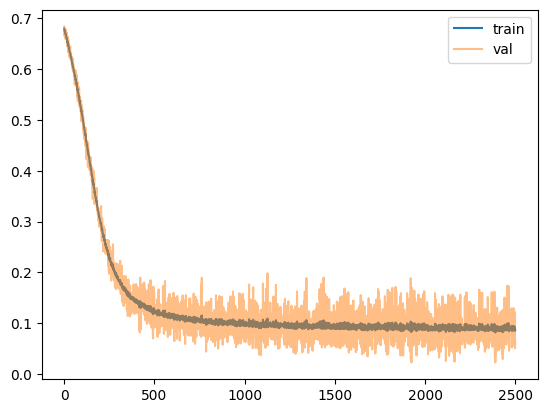

In [125]:
plt.plot(loss_history_train, label = 'train')
plt.plot(loss_history_val, label = 'val', alpha = 0.5)
plt.legend()

### CUDA acceleration

We can do computations on GPU. For that we need to move tensors on CUDA device using `.to('cuda')`. By default, torch uses 'cpu'.

The example below is adapted from [Introduction to PyTorch tutorial by Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html).

In [126]:
import time

a = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(a, a)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")


## GPU version
device = 'cuda'

a = a.to(device)

_ = torch.matmul(a, a)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(a, a)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 1.96837s
GPU time: 0.08762s


> Note: When `.to(device)` is applied to a tensor, it returns a new tensor. In the case of modules (e.g., model or criterion), the method modifies the module in place. Therefore, you need to reassign the variable when changing the device of a tensor, but you don't need to do this for modules.
```python

# in the case of a tensor
t = t.to(device)

# in the case of a module
model.to(device)
```

### Task 2: Train your MLP model for metal/insulator classification

- Split data into train/val/text
- Prepare DataLoader
- Train MLP
- Save model with the lowest validation loss

- Report accuracy on a test split

In [ ]:
# download files
!mkdir data
!wget -O./data/eg_double_perovskites.csv https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar05/eg_double_perovskites.csv

In [ ]:
df = pd.read_csv('data/eg_double_perovskites.csv')
df = df[df.columns[df.dtypes != 'object']]
df = df.drop(columns = ['PBE band gap']) # we exclude band gap from features

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):

        X = data.drop(columns = ['Insulator'])
        self.y = data['Insulator'].values # labels
        self.X = X.values # features

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        x_sample = self.X[idx] # one sample
        y_sample = self.y[idx] # one sample

        return x_sample, y_sample

In [ ]:
### Your code ###

### Code for toy example generation

In [ ]:
torch.manual_seed(42)

In [ ]:
import torch
import matplotlib.pyplot as plt

def line(x, W, b):
    return x * W + b



f1 = torch.linspace(0, 20, 20)

W = 50.3
b = 35.0
plt.figure(dpi = 300, figsize = (3, 3))
plt.plot(f1, line(f1, W, b), color = 'k', label = 'decision boundary', linewidth = 0.5, linestyle = '--')

torch.manual_seed(41)
f2_class_above = line(f1, W, b) + 500 * abs(torch.rand(len(f1)))
torch.manual_seed(41)
f2_class_below = line(f1, W, b) - 500 * abs(torch.rand(len(f1)))

plt.scatter(f1, f2_class_above, label = 'Class: 0')
plt.scatter(f1, f2_class_below, label = 'Class: 1')

plt.xlabel('f2')
plt.ylabel('f1')
plt.scatter(5, 750, color = 'r', marker = 'x', label = 'New sample')
plt.legend(fontsize = 7, frameon=False)



import pandas as pd

df = pd.DataFrame()
df['f1'] = f1
df['f2'] = f2_class_above
df['label'] = 1

df2 = pd.DataFrame()
df2['f1'] = f1
df2['f2'] = f2_class_below
df2['label'] = 0


table = pd.concat([df, df2])
#table.sample(frac=1).to_csv('data/linearly_separable_classes.csv', index = False)


In [ ]:
from sklearn.datasets import make_circles

X, labels = make_circles(n_samples=1000, noise = 0.2, factor = 0.3)

plt.figure(dpi = 300, figsize = (3, 3))
plt.scatter(*X.T, c = labels, s = 10)
plt.xlabel('f1')
plt.ylabel('f2')


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, labels.reshape(-1, 1))
y_preds = model.predict(X)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                    hidden_layer_sizes=(4, 2), random_state=1)

clf.fit(X, labels.reshape(-1, 1))
preds = clf.predict(X)

In [ ]:
plt.scatter(*X.T, c = preds)

In [ ]:


fix, (ax1, ax2) = plt.subplots(dpi = 300, figsize = (6, 3), ncols = 2)

ax1.scatter(*X.T, c = labels, s = 10)
ax1.set_xlabel('f1')
ax1.set_ylabel('f2')
ax1.set_title("True")
ax2.scatter(*X.T, c = preds, s = 10)
ax2.set_xlabel('f1')
ax2.set_ylabel('f2')
ax2.set_title("MLP prediction")
plt.tight_layout()

In [ ]:
import numpy as np
(preds == labels).sum() / len(preds)